## Importing Libraries
Imports all the necessary libraries for image processing (cv2, numpy), deep learning (tensorflow), data handling (sklearn), image similarity metrics (skimage), and plotting (matplotlib).

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

## Setting Paths and Parameters
Define the dataset path and target image size. Additionally, mixed precision training is enabled to optimize performance

In [7]:
# Define paths and parameters
dataset_path = '/kaggle/input/natural-images/natural_images/'
target_size = (256, 256)


# Utilize mixed precision training
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')


## Applying Sobel Filter
This function applies the Sobel filter to an image to detect edges by computing gradients in the x and y directions.

In [8]:
# Function to apply Sobel filter
def apply_sobel_filter(image):
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    return cv2.magnitude(sobel_x, sobel_y)

##  Loading and Processing Images
This code loads images from the specified dataset path, applies resizing, applies the Sobel filter, and normalizes the image data.

In [9]:
# Function to load and process images
def load_and_process_images(dataset_path, target_size):
    original_images = []
    sobel_images = []
    for category in os.listdir(dataset_path):
        category_path = os.path.join(dataset_path, category)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                resized_image = cv2.resize(image, target_size)
                original_images.append(resized_image)
                sobel_images.append(apply_sobel_filter(resized_image))

    return np.array(original_images), np.array(sobel_images)

# Load and process images
original_images, sobel_images = load_and_process_images(dataset_path, target_size)

# Expand dimensions and normalize
original_images = np.expand_dims(original_images, axis=-1) / 255.0
sobel_images = np.expand_dims(sobel_images, axis=-1) / 255.0

## Data Augmentation
The following code is commented out , due to memory restrictions on Kaggle. But incase you don't have any such limitations you can run the below code and change the variable names acordingly.

What it does: It creates new data samples by rotating images by 90 ,180 ,270 degreees , as the sobel filtered images will remain the same on orthogonal rotations.

In [ ]:
# import numpy as np

# # Function to perform rotation by 90, 180, and 270 degrees
# def rotate_images(images, sobel_images):
#     augmented_images = []
#     augmented_sobel_images = []
    
#     for image, sobel_image in zip(images, sobel_images):
#         # Add original images
#         augmented_images.append(image)
#         augmented_sobel_images.append(sobel_image)
        
# #         # Rotate 90 degrees
# #         rotated_image_90 = np.rot90(image, k=1)
# #         rotated_sobel_90 = np.rot90(sobel_image, k=1)
# #         augmented_images.append(rotated_image_90)
# #         augmented_sobel_images.append(rotated_sobel_90)
        
# #         # Rotate 180 degrees
# #         rotated_image_180 = np.rot90(image, k=2)
# #         rotated_sobel_180 = np.rot90(sobel_image, k=2)
# #         augmented_images.append(rotated_image_180)
# #         augmented_sobel_images.append(rotated_sobel_180)
        
# # #         Rotate 270 degrees
# #         rotated_image_270 = np.rot90(image, k=3)
# #         rotated_sobel_270 = np.rot90(sobel_image, k=3)
# #         augmented_images.append(rotated_image_270)
# #         augmented_sobel_images.append(rotated_sobel_270)
    
#     return np.array(augmented_images), np.array(augmented_sobel_images)

# # Apply the rotation-based augmentation
# X_augmented, y_augmented = rotate_images(original_images_resized, sobel_images_resized)

# # Verify the shapes
# print("Augmented Images Shape:", X_augmented.shape)
# print("Augmented Sobel Images Shape:", y_augmented.shape)

# # Split the data into training, validation, and test sets
# X_train, X_temp, y_train, y_temp = train_test_split(X_augmented, y_augmented, test_size=0.3, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# # Verify the split
# print("Training Set Shape:", X_train.shape)
# print("Validation Set Shape:", X_val.shape)
# print("Test Set Shape:", X_test.shape)


## Splitting the Data
This section splits the dataset into training, validation, and test sets.

In [10]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(original_images, sobel_images, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(X_train.shape,X_test.shape,X_val.shape)

(4829, 256, 256, 1) (1035, 256, 256, 1) (1035, 256, 256, 1)


## Defining the Neural Network model
This function defines a convolutional neural network for image filtering. It includes downsampling and upsampling paths with residual connections for enhanced feature extraction and reconstruction.

MSE as a loss function helps the model learn more effectively by penalizing larger errors, leading to a more robust fit during training.

MAE as a metric provides a user-friendly measure of model performance, making it easier to understand how well the model is doing in terms of prediction accuracy.

In [11]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


# Define the improved Sobel model
def create_improved_sobel_model(input_shape):
    inputs = Input(shape=input_shape)

    # Downsample
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv2)
    conv3 = BatchNormalization()(conv3)

    # Upsample
    up1 = UpSampling2D((2, 2))(conv3)
    up1 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)

    conv2_upsampled = UpSampling2D((2, 2))(conv2)
    up1 = Add()([up1, conv2_upsampled])

    up2 = UpSampling2D((2, 2))(up1)
    up2 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)
    up2 = BatchNormalization()(up2)

    conv1_upsampled = UpSampling2D((2, 2))(conv1)
    up2 = Add()([up2, conv1_upsampled])

    outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

input_shape = (256, 256, 1)

## Setting Up and Compiling the Model
his section sets up model parallelism with TensorFlow’s MirroredStrategy for distributed training.

In [12]:
# Implement Model Parallelism using MirroredStrategy
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    input_shape = (256, 256, 1)
    model = create_improved_sobel_model(input_shape)

    # Compile the model inside the strategy scope
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 256, 256,  │        640 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │    295,040 │ up_sampling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_5     │ (None, 128, 128,  │          0 │ max_pooling2d_3[… │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │ up_sampling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_6     │ (None, 256, 256,  │          0 │ add_2[0][0]       │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 256, 256,  │     73,792 │ up_sampling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_10[0][0] 

 Total params: 741,633 (2.83 MB)

 Trainable params: 740,353 (2.82 MB)

 Non-trainable params: 1,280 (5.00 KB)

## Training the Model
This section defines a learning rate scheduler and early stopping callback, then trains the model with these callbacks.

In [13]:
# Define learning rate scheduler and early stopping
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    elif epoch < 10:
        return lr * tf.math.exp(-0.1).numpy()
    else:
        return lr * tf.math.exp(-0.5).numpy()

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=15,
    validation_data=(X_val, y_val),
    batch_size=16,
    callbacks=[lr_callback, early_stopping]
)


Epoch 1/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 84s 197ms/step - loss: 0.0545 - mae: 0.1399 - val_loss: 0.0793 - val_mae: 0.1553 - learning_rate: 0.0010
Epoch 2/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 51s 167ms/step - loss: 0.0190 - mae: 0.0680 - val_loss: 0.0296 - val_mae: 0.0915 - learning_rate: 0.0010
Epoch 3/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 51s 168ms/step - loss: 0.0165 - mae: 0.0592 - val_loss: 0.0194 - val_mae: 0.0701 - learning_rate: 0.0010
Epoch 4/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 51s 168ms/step - loss: 0.0158 - mae: 0.0568 - val_loss: 0.0197 - val_mae: 0.0752 - learning_rate: 0.0010
Epoch 5/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 51s 170ms/step - loss: 0.0150 - mae: 0.0523 - val_loss: 0.0165 - val_mae: 0.0545 - learning_rate: 0.0010
Epoch 6/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 52s 170ms/step - loss: 0.0150 - mae: 0.0509 - val_loss: 0.0158 - val_mae: 0.0504 - learning_rate: 9.0484e-04
Epoch 7/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 52s 171ms/step - loss: 0.0147 - mae: 0.0497 - val_loss: 0.0176 - val_mae: 0.0654 - lea

## Plotting Training Results
These plots visualize the training and validation loss and Mean Absolute Error (MAE) over the epochs, helping to understand the model’s performance.

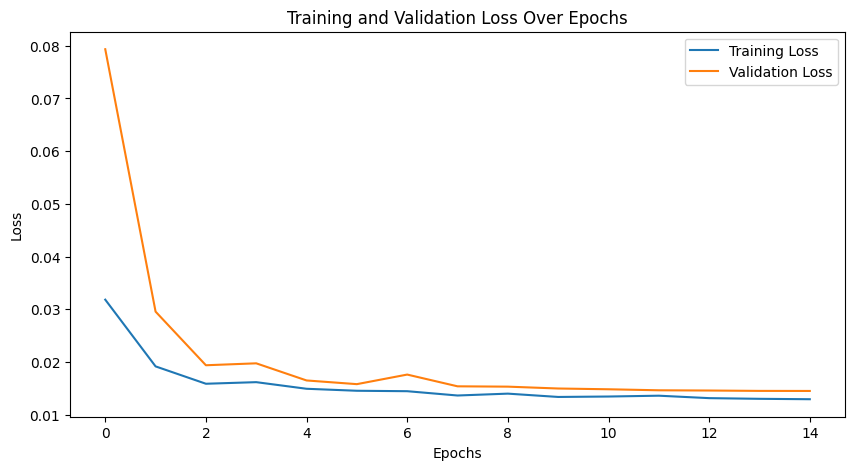

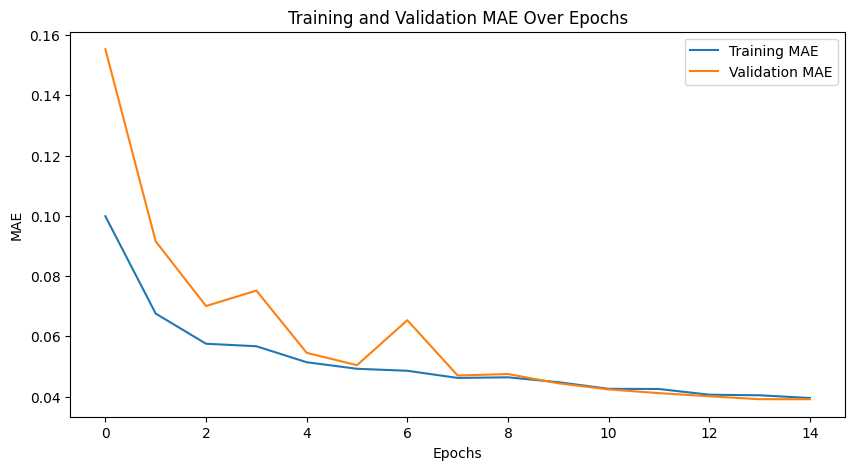

In [14]:
# Plotting training and validation loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting MAE over epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

## Evaluating and Testing the Model

In [15]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate SSIM for all images in the test set
ssim_values = []
for i in range(len(X_test)):
    ssim_value = ssim(y_test[i].squeeze(), y_pred[i].squeeze(), data_range=1.0)
    ssim_values.append(ssim_value)

# Calculate average SSIM for the test set
average_ssim = np.mean(ssim_values)
print(f"Average SSIM for the test set: {average_ssim}")

# Calculate accuracy by comparing binary masks
def calculate_accuracy(y_true, y_pred, threshold=0.01):
    y_true_binary = (y_true > threshold).astype(int)
    y_pred_binary = (y_pred > threshold).astype(int)
    accuracy = np.mean(y_true_binary == y_pred_binary)
    return accuracy

# Calculate accuracy for the test set
test_accuracy = calculate_accuracy(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 0.0151 - mae: 0.0405
Test Loss: 0.0130344582721591
Test MAE: 0.038820914924144745
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step
Average SSIM for the test set: 0.9043157354107026
Test Accuracy: 94.82%


In [20]:

# Calculate accuracy by comparing binary masks
def calculate_accuracy(y_true, y_pred, threshold=0.001):
    y_true_binary = (y_true > threshold).astype(int)
    y_pred_binary = (y_pred > threshold).astype(int)
    accuracy = np.mean(y_true_binary == y_pred_binary)
    return accuracy

# Calculate accuracy for the test set
test_accuracy = calculate_accuracy(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Test Accuracy: 96.36%
